# Runing some tests on treaty ratification dataset

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn import preprocessing

In [4]:
# This is a merge of a variety of datasets on treaty ratification for the
# 9 UN human rights treaties,
# It has days from opening of treaty to ratification counted and
# a binary for ratified / not ratified,
# as wel as exogenous variables on mean HDI score, mean GDP, years of uninterrumpted
# democracy at 2015 and religion.
# The data wrangling is not perfect. Since state names change (ie. Venezuela
# vs Bolivarian Republic of Venezuela, etc.) the merge operation 
# ended up dropping observations, but it is sufficient to start doing some tests

df = pd.read_csv('https://raw.githubusercontent.com/g-arosemena/pilot/main/df_simple.csv?token=AQFSLYV7JUSAZKDH2L7I6TDACPF2M')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143 entries, 0 to 142
Data columns (total 24 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     143 non-null    int64  
 1   country        143 non-null    object 
 2   td_ICCPR       133 non-null    float64
 3   td_ICESCR      134 non-null    float64
 4   td_ICERD       141 non-null    float64
 5   td_CEDAW       142 non-null    float64
 6   td_CRC         143 non-null    float64
 7   td_CAT         131 non-null    float64
 8   td_CRPD        137 non-null    float64
 9   td_CPED        58 non-null     float64
 10  td_ICRMW       47 non-null     float64
 11  bin_ICCPR      143 non-null    int64  
 12  bin_ICESCR     143 non-null    int64  
 13  bin_ICERD      143 non-null    int64  
 14  bin_CEDAW      143 non-null    int64  
 15  bin_CRC        143 non-null    int64  
 16  bin_CAT        143 non-null    int64  
 17  bin_CRPD       143 non-null    int64  
 18  bin_CPED  

In [5]:
# I need to encode religion as a numerical for sklearn / numpy. 

le = preprocessing.LabelEncoder()
le.fit(df['Main.religion'])
df['rel'] = le.transform(df['Main.religion'])

In [6]:
# Let's try to predict ICCPR ratifications with our exogenous variables:
# mean hdi, mean gdp, years of democracy and religion. Here we designate
# the "target", and the "features". We have to turn them into np arrays
# for sklearn
y = df['bin_ICCPR'].values
X = df[['hdi_m', 'gdp_m','span_y', 'rel']].values

In [7]:
# The train test split which allows us to test out of sample predictive power
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state=25)


In [8]:
# first we set up a knn classifier to predict the binary outcome
# in light of the exog variables.

clf1 = KNeighborsClassifier(n_neighbors=3).fit(X_train,y_train)


In [9]:
# Here we make out of sample predictions and get the predicion score
y_pred = clf1.predict(X_test)
print(y_pred[0:21])
print(clf1.score(X_test, y_test))

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
0.9534883720930233


C:\Users\gusta\anaconda3\envs\Gustavo_1\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=9.
  warnings.warn(("The least populated class in y has only %d"


[1.  1.  1.  1.  1.  0.8 0.8 1.  1. ]
Average 5-Fold CV Score: 0.9555555555555555


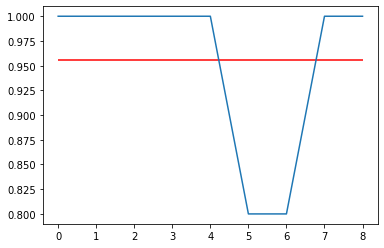

In [10]:
# we get cross nine-fold validation scores and plot them. Probably not the right model (see the warning)
cv_scores1 = cross_val_score(clf1,X_test,y_test,cv=9)
print(cv_scores1)
fig, ax = plt.subplots()
ax.plot(cv_scores1)
ax.hlines(y=np.mean(cv_scores1),xmin=0,xmax=8, color = 'red')
print("Average 5-Fold CV Score: {}".format(np.mean(cv_scores1)))

[[ 0  2]
 [ 0 41]]


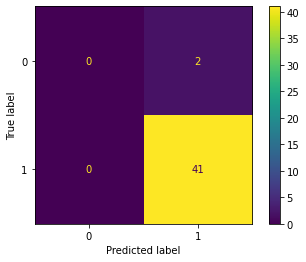

In [11]:
# Confusion matrix tells us about the correct and
# incorrect classification and types of error.
print(confusion_matrix(y_test,y_pred))
plot_confusion_matrix(clf1, X_test,y_test)


In [12]:
# Now lets try a decision tree model
clf3 = DecisionTreeClassifier().fit(X_train,y_train)
y_pred = clf3.predict(X_test)
print(y_pred[0:21])
print(clf3.score(X_test, y_test))


[1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1]
0.8604651162790697


C:\Users\gusta\anaconda3\envs\Gustavo_1\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=9.
  warnings.warn(("The least populated class in y has only %d"


[1.  1.  1.  1.  1.  0.8 0.8 1.  1. ]
Average 5-Fold CV Score: 0.9555555555555555


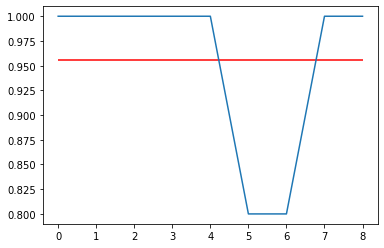

In [14]:
# Cross validation for out of sample prediction. Think something is wrong here. I am getting the same CV scores even 
# though I fit a different model
cv_scores3 = cross_val_score(clf3,X_test,y_test,cv=9)
print(cv_scores3)
fig2, ax2 = plt.subplots()
ax2.plot(cv_scores3)
ax2.hlines(y=np.mean(cv_scores3),xmin=0,xmax=8, color = 'red')
print("Average 5-Fold CV Score: {}".format(np.mean(cv_scores3)))

[[ 0  2]
 [ 4 37]]


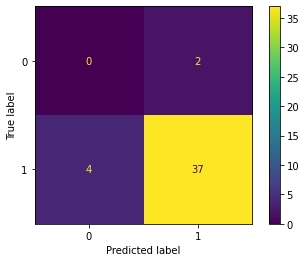

In [15]:
# Confusion matrix
print(confusion_matrix(y_test,y_pred))
plot_confusion_matrix(clf3, X_test,y_test)

In [16]:
# I could get the feature importances from the tree model (not from the knn one?)
# This might be the most important info. HDI and GDP are the most important
# predictor of ratification. I think there is a way to get pvalues from tree 
# models.   
clf3.feature_importances_

array([0.33589976, 0.37638614, 0.13371291, 0.15400119])

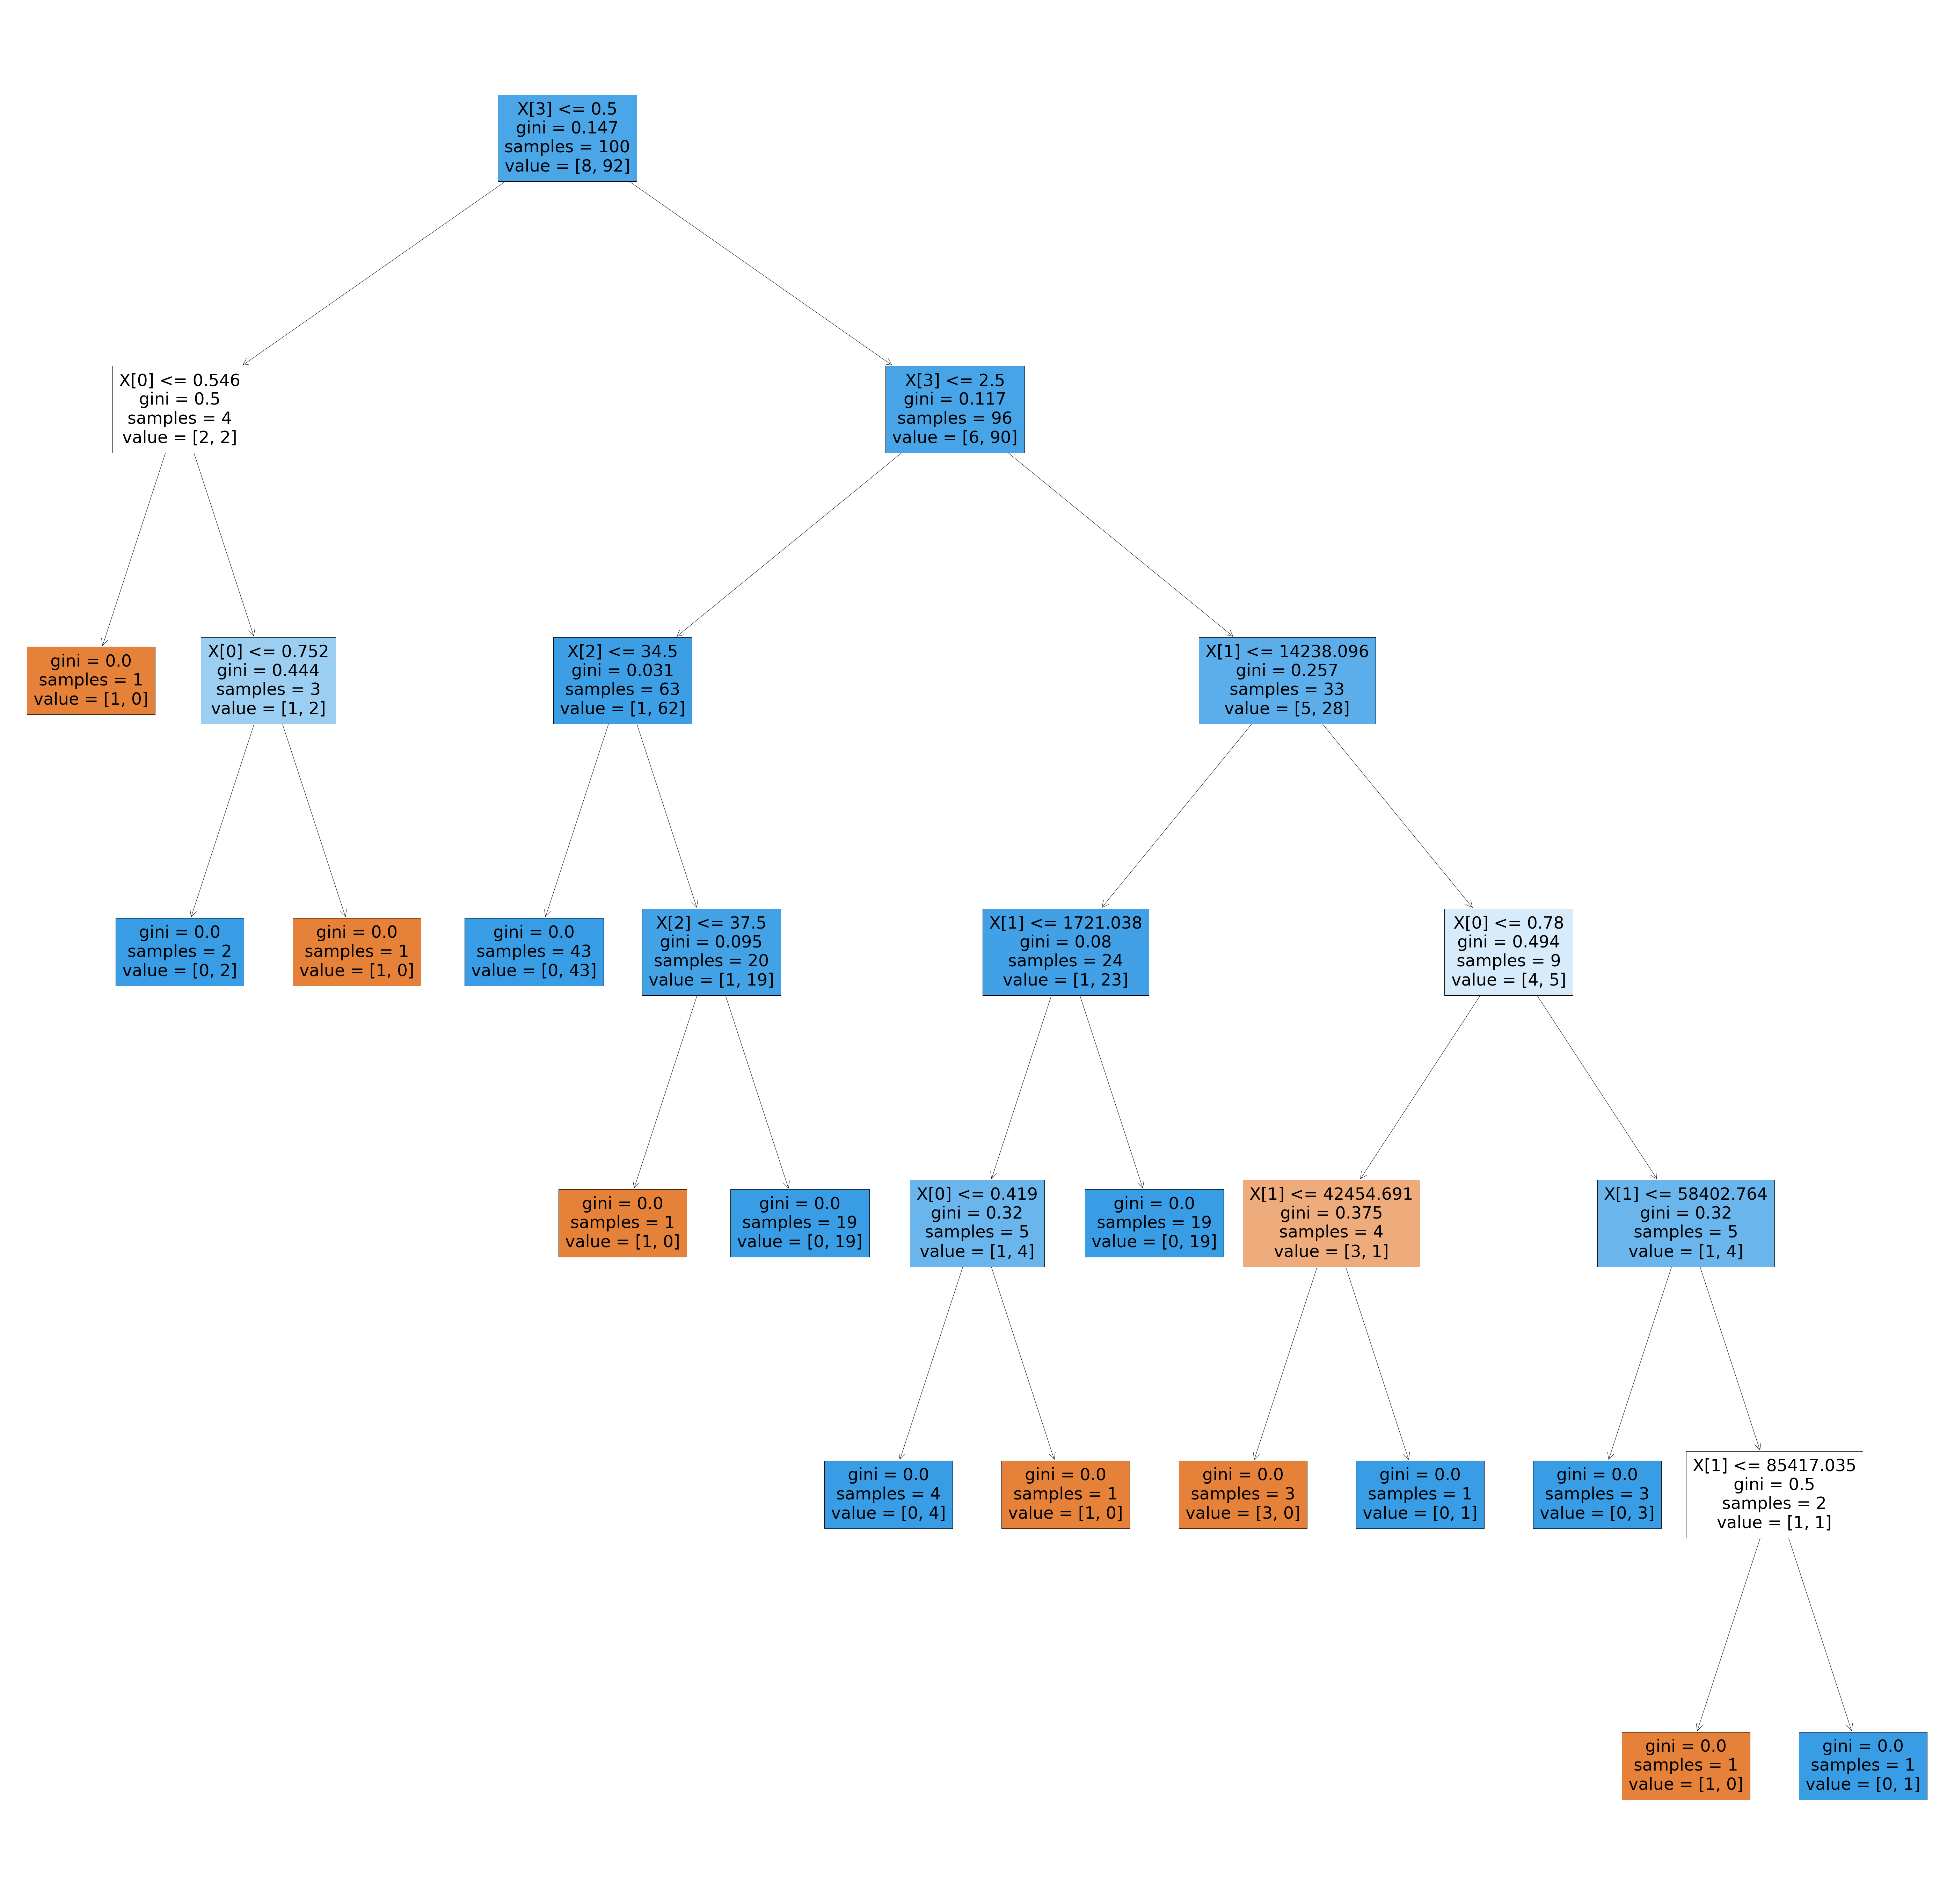

In [17]:

# Let's plot the tree. I had to struggle to find a way to make the image
# readable. Plot below can be recycled.
# Something seems to be going wrong with feature 3 (religion). I think it is treating it as continous whereas I want it to be
# categorical
# A tree model would be the most interesting for maybe effects of variable is non linear (ie high only for mid-range hdi/gdp countries)

fig, ax = plt.subplots(figsize=(100, 100))
plot_tree(clf3, filled=True, ax=ax)
plt.show()
